In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 214MB/s]



Epoch [1/50]
Training - Loss: 0.3319, Accuracy: 0.8676
Validation - Loss: 0.3947, Accuracy: 0.8164

Epoch [2/50]
Training - Loss: 0.2084, Accuracy: 0.9243
Validation - Loss: 0.3471, Accuracy: 0.8521

Epoch [3/50]
Training - Loss: 0.1769, Accuracy: 0.9392
Validation - Loss: 0.5831, Accuracy: 0.8767

Epoch [4/50]
Training - Loss: 0.2434, Accuracy: 0.9208
Validation - Loss: 0.4297, Accuracy: 0.8219

Epoch [5/50]
Training - Loss: 0.1706, Accuracy: 0.9463
Validation - Loss: 0.2608, Accuracy: 0.8822

Epoch [6/50]
Training - Loss: 0.1231, Accuracy: 0.9550
Validation - Loss: 0.1747, Accuracy: 0.9479

Epoch [7/50]
Training - Loss: 0.0942, Accuracy: 0.9678
Validation - Loss: 0.1461, Accuracy: 0.9479

Epoch [8/50]
Training - Loss: 0.0882, Accuracy: 0.9698
Validation - Loss: 0.1716, Accuracy: 0.9370

Epoch [9/50]
Training - Loss: 0.1001, Accuracy: 0.9622
Validation - Loss: 0.2253, Accuracy: 0.9479

Epoch [10/50]
Training - Loss: 0.0781, Accuracy: 0.9709
Validation - Loss: 0.1753, Accuracy: 0.9288

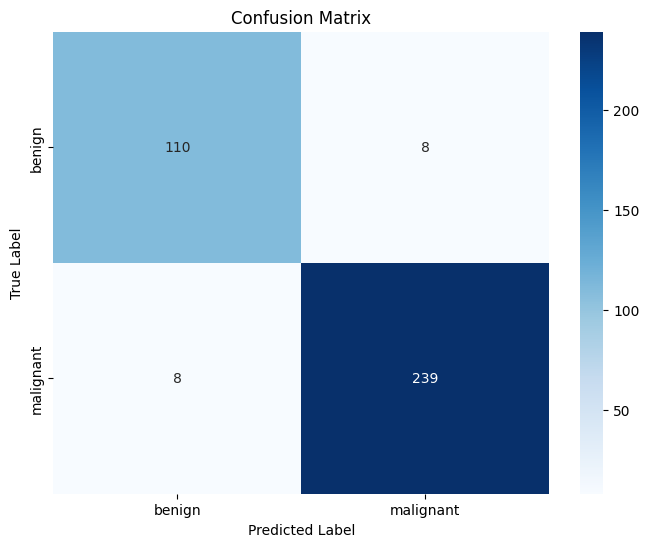

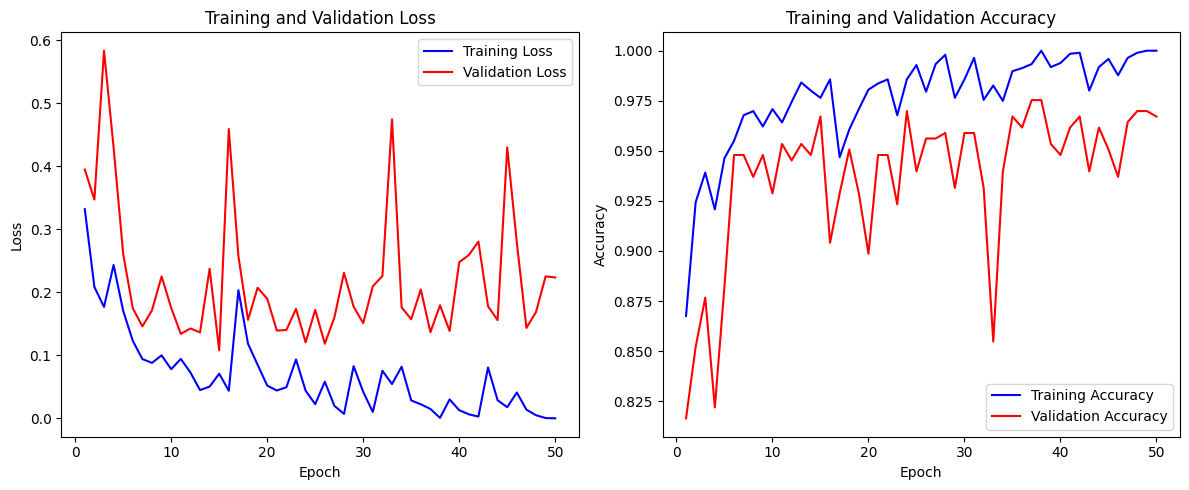

In [ ]:

# Paths to datasets
train_path = '/content/drive/MyDrive/BreakHis/BreaKHis_v1/breast_resized/train'
test_path = '/content/drive/MyDrive/BreakHis/BreaKHis_v1/breast_resized/test'

# Model parameters
img_size = 224
batch_size = 32
num_classes = 2
learning_rate = 1e-4
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data augmentation and transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained VGG16 model and modify the FC layer
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, num_classes)  # Replace the FC layer
vgg16 = vgg16.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vgg16.parameters(), lr=learning_rate)

# For storing metrics
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Training and validation loop
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # Training
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = vgg16(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

        # Print metrics for each batch
        batch_loss = loss.item()
        batch_accuracy = (predicted == targets).sum().item() / targets.size(0)
        #print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.4f}")

    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    print(f"Training - Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")

    # Validation
    vgg16.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    batch_val_losses, batch_val_accuracies = [], []

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data, targets = data.to(device), targets.to(device)
            outputs = vgg16(data)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

            # Print metrics for each validation batch
            batch_loss = loss.item()
            batch_accuracy = (predicted == targets).sum().item() / targets.size(0)
            batch_val_losses.append(batch_loss)
            batch_val_accuracies.append(batch_accuracy)
            #print(f"  Validation Batch [{batch_idx+1}/{len(test_loader)}] - Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.4f}")

    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)

    print(f"Validation - Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}")

# Final Metrics
vgg16.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = vgg16(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_targets, all_preds)

print(f"\nFinal Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_loader.dataset.classes,
            yticklabels=test_loader.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot Training and Validation Loss/Accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
